## Display function

In [1]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by='fpr').reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Function for filtering the result_list

In [2]:
import numpy as np
from sklearn.metrics import roc_curve
def filter_roc_results(results_list, results_original_roc, depth=1):
    """
    Filters the ROC results to include only those that are better than the original ROC curve.
    Each results_list item will compare its TPR against the original ROC curve's TPR at the same FPR.
    This function assumes that the results_list contains dictionaries with 'fpr', 'tpr' keys.
    If the TPR of a model at a given FPR is greater than the original model's TPR,
    it is considered a better model and included in the filtered results.
    If the FPR of a model is not present in the original ROC curve, then extrapolate
    the TPR value from the original ROC curve using linear interpolation.
    If the TPR of a model for a given FPR is equal to or worse than the original model's TPR, then
    we compute ROC results of the previous model in the list and compare the TPR with the original_model TPR for that FPR.
    If the above step still does not yield a better model, then we perform the same operation for the next model in the list.
    If still we do not find a better model, then we pick the original model as the best model for that FPR.
    The depth parameter defines how many models to look back and forward in the list
    to find a substitute model that performs better than the original model at the same FPR. 

    Args:
        results_list: A list of dictionaries containing the ROC results of the models.
        results_original_roc: A dictionary containing the ROC results of the original model.

    Returns:
        A filtered list of dictionaries containing only the relevant ROC results.
    """
    final_roc_points = []
    original_fprs = np.array(results_original_roc['fpr'])
    original_tprs = np.array(results_original_roc['tpr'])
    original_thresholds = np.array(results_original_roc['thresholds'])

    for i, current_data in enumerate(results_list):
        current_fpr = current_data["fpr"]
        current_tpr = current_data["tpr"]
        current_threshold = current_data["threshold"]

        original_tpr_at_current_fpr = np.interp(current_fpr, original_fprs, original_tprs)

        # 1. Is the current model's point better than the baseline?
        if current_tpr > original_tpr_at_current_fpr:
            final_roc_points.append({
                "model": current_data["model"],
                "fpr": current_fpr,
                "tpr": current_tpr,
                "threshold": current_threshold
            })
            continue

        # 2. NO. Search for the best substitute within the defined depth.
        best_substitute = None
        # Start by assuming the baseline is the best we can do. We need to beat this.
        best_substitute_tpr = original_tpr_at_current_fpr

        # Define the search window
        start_index = max(0, i - depth)
        end_index = min(len(results_list), i + depth + 1)

        for j in range(start_index, end_index):
            # Don't compare the model with itself
            if i == j:
                continue

            candidate_data = results_list[j]
            candidate_roc = candidate_data["full_roc"]
            
            # Find the candidate's performance at the current FPR
            candidate_tpr = np.interp(current_fpr, candidate_roc["fpr"], candidate_roc["tpr"])

            # If this candidate is the best substitute found so far...
            if candidate_tpr > best_substitute_tpr:
                best_substitute_tpr = candidate_tpr
                
                # ...find its corresponding threshold and store its info.
                idx = np.searchsorted(candidate_roc["fpr"], current_fpr)
                chosen_threshold = candidate_roc["thresholds"][max(0, idx - 1)]
                best_substitute = {
                    "model": candidate_data["model"],
                    "tpr": candidate_tpr,
                    "threshold": chosen_threshold
                }
        
        # 3. After searching, did we find a worthy substitute?
        if best_substitute:
            # YES. A substitute from the window was better than the baseline.
            best_substitute["fpr"] = current_fpr # Add the FPR to the dict
            final_roc_points.append(best_substitute)
        else:
            # NO. No model in the window was better. Fall back to the baseline.
            idx = np.searchsorted(original_fprs, current_fpr)
            chosen_threshold = original_thresholds[max(0, idx - 1)]
            final_roc_points.append({
                "model": "original_baseline",
                "fpr": current_fpr,
                "tpr": original_tpr_at_current_fpr,
                "threshold": chosen_threshold
            })

    # Find the min and max FPR values in the final results
    # if min FPR is greater than 0, use the operation points from 0 to min FPR of the model with the min FPR to fill the gap
    # we do the same for the max FPR less than 1
     # If no points were selected, return an empty list
    if not final_roc_points:
        return []

    # --- Start of the completed section ---

    # Find the point with the minimum FPR to start the curve
    min_fpr_point = min(final_roc_points, key=lambda x: x['fpr'])
    min_fpr_val = min_fpr_point['fpr']
    min_fpr_model_name = min_fpr_point['model']

    initial_points = []
    if min_fpr_val > 0:
        # Get the full ROC of the model with the minimum FPR
        if min_fpr_model_name == 'original_baseline':
            min_model_roc = results_original_roc
        else:
            min_model_data = next((item for item in results_list if item['model'] == min_fpr_model_name), None)
            min_model_roc = min_model_data['full_roc'] if min_model_data else None

        if min_model_roc:
            roc_fprs = np.array(min_model_roc['fpr'])
            roc_tprs = np.array(min_model_roc['tpr'])
            roc_thresholds = np.array(min_model_roc['thresholds'])
            
            indices_to_add = np.where(roc_fprs < min_fpr_val)[0]
            for idx in indices_to_add:
                initial_points.append({
                    "model": min_fpr_model_name,
                    "fpr": roc_fprs[idx],
                    "tpr": roc_tprs[idx],
                    "threshold": roc_thresholds[idx]
                })

    # Find the point with the maximum FPR to end the curve
    max_fpr_point = max(final_roc_points, key=lambda x: x['fpr'])
    max_fpr_val = max_fpr_point['fpr']
    max_fpr_model_name = max_fpr_point['model']
    
    trailing_points = []
    if max_fpr_val < 1.0:
        # Get the full ROC of the model with the maximum FPR
        if max_fpr_model_name == 'original_baseline':
            max_model_roc = results_original_roc
        else:
            max_model_data = next((item for item in results_list if item['model'] == max_fpr_model_name), None)
            max_model_roc = max_model_data['full_roc'] if max_model_data else None
        
        if max_model_roc:
            roc_fprs = np.array(max_model_roc['fpr'])
            roc_tprs = np.array(max_model_roc['tpr'])
            roc_thresholds = np.array(max_model_roc['thresholds'])

            indices_to_add = np.where(roc_fprs > max_fpr_val)[0]
            for idx in indices_to_add:
                trailing_points.append({
                    "model": max_fpr_model_name,
                    "fpr": roc_fprs[idx],
                    "tpr": roc_tprs[idx],
                    "threshold": roc_thresholds[idx]
                })

    # Combine all points
    combined_points = initial_points + final_roc_points + trailing_points

    # Sort by FPR (and then by descending TPR to keep the best point) and remove duplicates
    combined_points.sort(key=lambda p: (p['fpr'], -p['tpr']))
    
    unique_roc_points = []
    seen_fprs = set()
    for point in combined_points:
        if point['fpr'] not in seen_fprs:
            unique_roc_points.append(point)
            seen_fprs.add(point['fpr'])

    return unique_roc_points

## Data generation

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1000
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 250
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)
        val_data = test_data
        
        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1000
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 250
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)
        val_data = test_data
        
        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    return train_data, test_data, val_data


## Calculate Statistics function

In [4]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test, threshold=0.5):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_prob = clf_model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





## PneumoniaMNIST: NN

In [5]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

In [6]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes, image_height, image_width):
        super(SimpleCNN, self).__init__()
        #Convoluional layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 224x224 -> 112x112
        
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 112x112 -> 56x56
        
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56x56 -> 28x28
        
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 28x28 -> 14x14
        )

        # --- DYNAMIC FLATTENED SIZE CALCULATION ---
        # Create a dummy tensor with the specified input dimensions
        dummy_input = torch.randn(1, in_channels, image_height, image_width)
        # Pass it through the feature extractor to see the output shape
        dummy_output = self.features(dummy_input)
        # The number of elements in the output tensor is our flattened size
        self.flattened_size = dummy_output.numel()

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.relu_fc = nn.ReLU()
        # Output layer: num_classes=1 for binary classification (outputting logits)
        self.fc2 = nn.Linear(512, num_classes)

    def extract_features(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.fc1(x)
        x = self.relu_fc(x)
        return x

    def forward(self, x):
        x = self.extract_features(x)
        x = self.fc2(x)
        return x

### Lightning module

In [8]:
import torchmetrics
import pytorch_lightning as pl

class LitSimpleCNN(pl.LightningModule):
    def __init__(self, in_channels, num_classes, learning_rate, image_height, image_width, training_mode='full_network'):
        super().__init__()
        # Save hyperparameters
        self.save_hyperparameters()
        
        # Define the model
        self.model = SimpleCNN(
            in_channels=self.hparams.in_channels, 
            num_classes=self.hparams.num_classes,
            image_height=self.hparams.image_height,
            image_width=self.hparams.image_width
        )
        
        # Define loss function
        self.criterion = nn.BCEWithLogitsLoss()

        # Define metrics
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.val_accuracy = torchmetrics.Accuracy(task="binary")
        self.val_auc = torchmetrics.AUROC(task="binary")

        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_auc = torchmetrics.AUROC(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary")
        self.test_recall = torchmetrics.Recall(task="binary")
        self.test_f1 = torchmetrics.F1Score(task="binary")

        # This list will store outputs from each test step
        self.last_test_results = {}
        self.test_step_outputs = []


    def forward(self, x):
        return self.model(x)
    
    def freeze_feature_extractor(self):
        print("Freezing feature extractor layers...")
        for param in self.model.features.parameters():
            param.requires_grad = False
        for param in self.model.fc1.parameters():
            param.requires_grad = False

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        # For BCEWithLogitsLoss, labels must be float
        labels = labels.float()
        
        outputs = self(inputs) # Forward pass
        loss = self.criterion(outputs, labels)

        # We need to handle which part of the network we are training
        if self.hparams.training_mode == 'full_network':
            self.log('train_loss_full', loss)
        elif self.hparams.training_mode == 'classifier_only':
            self.log('train_loss_classifier', loss)
        
        # Log metrics
        self.train_accuracy(outputs, labels.int())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        labels = labels.float()
        
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        
        # Log metrics
        self.val_accuracy(outputs, labels.int())
        self.val_auc(outputs, labels.int())
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('val_acc', self.val_accuracy, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('val_auc', self.val_auc, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels.float())
        
        # Append predictions and labels to our list
        self.test_step_outputs.append({"preds": outputs.detach(), "labels": labels.detach()})
        
        # Log the loss for this batch
        self.log('test_loss', loss)
        return {"loss": loss}

    def on_test_epoch_end(self):
        # Concatenate all predictions and labels from the list we built
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # Calculate final metrics over the entire test set
        test_acc = self.test_accuracy(all_preds, all_labels.int())
        test_auc_val = self.test_auc(all_preds, all_labels.int())
        test_prec = self.test_precision(all_preds, all_labels.int())
        test_rec = self.test_recall(all_preds, all_labels.int())
        test_f1_val = self.test_f1(all_preds, all_labels.int())
        test_cm_val = torchmetrics.functional.confusion_matrix(all_preds, all_labels.int(), task="binary")

        # Log the final metrics
        self.log("test_acc_epoch", test_acc)
        self.log("test_auc_epoch", test_auc_val)

        print(f"\n--- Final Test Metrics ---")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"AUC: {test_auc_val:.4f}")
        print(f"Precision: {test_prec:.4f}")
        print(f"Recall: {test_rec:.4f}")
        print(f"F1-Score: {test_f1_val:.4f}")
        print(f"Confusion Matrix:\n{test_cm_val}")
        print("--------------------------\n")

        # Calculate data for the ROC Curve
        fpr, tpr, thresholds = torchmetrics.functional.roc(
            torch.sigmoid(all_preds),
            all_labels.int(),
            task="binary"
        )

        # Store the results to be retrieved later in the main script
        self.last_test_results = {
            "fpr": fpr.cpu(),
            "tpr": tpr.cpu(),
            "auc": test_auc_val,
            "f1": test_f1_val,
            "precision": test_prec,
            "recall": test_rec,
            "cm": test_cm_val,
            "thresholds": thresholds.cpu(),
        }
        # Free up memory
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

### Generate data

In [9]:
train_dataset, test_dataset, val_dataset = generate_data("pneumoniaMNIST")

# Ensure you have your train_loader and val_loader defined here
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset.transform = data_transforms
test_dataset.transform = data_transforms
val_dataset.transform = data_transforms


train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
#new_train_loader = data.DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) to be done inside the sample_ratio loop
test_loader = data.DataLoader(test_dataset, batch_size=int(BATCH_SIZE/4), shuffle=False, num_workers=NUM_WORKERS)
val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

3.0.2
Number of training samples: 4708
Number of test samples: 624
Number of validation samples: 524


In [10]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)
best_model_paths = [] # List to store the path of the best model from each stage

# 1. Instantiate the LightningModule
model = LitSimpleCNN(
    in_channels=NUM_CHANNELS,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE,
    training_mode='full_network',  # Change to 'classifier_only' if you want to train only the classifier
    image_height=IMAGE_SIZE,
    image_width=IMAGE_SIZE
)

# Optional: Print model summary
# You need to move the model to a device first for torchsummary to work
# summary(model.to('cuda'), (NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))
# model.to('cpu') # Move it back if needed

checkpoint_callback_full_model = ModelCheckpoint(
    monitor='val_acc',
    dirpath='checkpoints/',
    filename='simple-cnn-full-{epoch:02d}-{val_acc:.2f}',
    save_top_k=1,
    mode='max',
)

train_trainer_1 = pl.Trainer(
    accelerator='gpu',                 # Use GPUs
    devices=1,                         # Number of GPUs to use
    #strategy='ddp_notebook',                    # DistributedDataParallel strategy (best for multi-GPU)
    max_epochs=NUM_EPOCHS,              # Total number of epochs
    callbacks=[checkpoint_callback_full_model, progress_bar],
    logger=pl.loggers.TensorBoardLogger("lightning_logs/", name="simple_cnn-full")
)

test_trainer_1 = pl.Trainer(
    accelerator='gpu',
    devices=1,  # Use only one GPU
    logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="simple_cnn_test"),
    # Add the callback here so the Trainer can find the 'best' path
    callbacks=[checkpoint_callback_full_model],
    precision='16-mixed'  # Use mixed precision for testing
)


# --- Phase 1 Training ---
print(f"--- Starting Training for {NUM_EPOCHS} epochs on train_loader ---")
train_trainer_1.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# CRITICAL: Save the path to the best model from this phase
path_after_phase1 = checkpoint_callback_full_model.best_model_path
print(f"Best model from Phase 1 saved to: {path_after_phase1}")

# --- Test 1: Evaluate the model from after Phase 1 ---
print(f"\n--- Testing model from Phase 1 checkpoint: {path_after_phase1} ---")
model.current_test_title = "ROC Curve after training on DataLoader 1"
model = LitSimpleCNN.load_from_checkpoint(path_after_phase1)  # Load the model from Phase 1
model.eval().to('cuda:0')  # Ensure the model is in evaluation mode and on GPU
test_trainer_1.test(model, dataloaders=test_loader, ckpt_path=path_after_phase1)
results_phase1 = model.last_test_results.copy()
results_original_roc = {"fpr": results_phase1["fpr"], "tpr": results_phase1["tpr"], "thresholds": results_phase1["thresholds"], "name": "Original NN PneumoniaMNIST", "auc": results_phase1["auc"], "model": model}

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


--- Starting Training for 1 epochs on train_loader ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------------
2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Best model from Phase 1 saved to: /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-full-epoch=00-val_acc=0.93-v3.ckpt

--- Testing model from Phase 1 checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-full-epoch=00-val_acc=0.93-v3.ckpt ---


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-full-epoch=00-val_acc=0.93-v3.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-full-epoch=00-val_acc=0.93-v3.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Test Metrics ---
Accuracy: 0.8558
AUC: 0.9216
Precision: 0.8409
Recall: 0.9487
F1-Score: 0.8916
Confusion Matrix:
tensor([[164,  70],
        [ 20, 370]], device='cuda:0')
--------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.8557692170143127
     test_auc_epoch         0.9215538501739502
        test_loss           0.3674173951148987
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Undersampling based ROC curve

In [11]:
import numpy as np
from collections import Counter

# --- This block generates the list of ratios for your experiment ---

# 1. Get original class counts from your train_dataset
try:
    original_labels = np.array(train_dataset.labels).flatten()
except AttributeError:
    original_labels = np.array(train_dataset.targets).flatten()

original_counts = Counter(original_labels)
num_pos_original = original_counts.get(1, 0)  # e.g., 3494 (Pneumonia)
num_neg_original = original_counts.get(0, 0)  # e.g., 1214 (Normal)

# The pivot point for your function's logic
orig_sample_ratio = num_pos_original / num_neg_original # ~2.88

# 2. Define how many steps for each regime
N_POINTS_PER_REGIME = 20  # You can change this

# 3. Generate ratios for Regime 1 (from near 0 up to the pivot)
# This will test scenarios from extreme negative-class dominance up to the original balance.
print("Generating ratios for Regime 1 (target ratio < 2.88)...")
ratios_regime1 = np.geomspace(
    start=0.001,                      # A small starting ratio (e.g., 1 positive for every 10 negatives)
    stop=orig_sample_ratio,         # Go up to the original ratio
    num=N_POINTS_PER_REGIME,
    endpoint=False                  # Exclude the pivot itself to avoid the 'else' block
)

# 4. Generate ratios for Regime 2 (from the pivot up to 3494)
# This will test scenarios from the original balance up to extreme positive-class dominance.
print("Generating ratios for Regime 2 (target ratio > 2.88)...")
ratios_regime2 = np.geomspace(
    start=orig_sample_ratio, # Start just above the pivot
    stop=3494,                      # Your specified upper limit
    num=N_POINTS_PER_REGIME
)

# 5. Combine, sort, and create the final list for the loop
#    We also add the original ratio to ensure we have a baseline run.
all_ratios = sorted(list(np.concatenate([ratios_regime1, ratios_regime2, [orig_sample_ratio]])))

print(f"\nGenerated {len(all_ratios)} unique sample ratios to test.")
print("First few ratios:", np.round(all_ratios[:5], 3))
print("Last few ratios:", np.round(all_ratios[-5:], 2))

Generating ratios for Regime 1 (target ratio < 2.88)...
Generating ratios for Regime 2 (target ratio > 2.88)...

Generated 41 unique sample ratios to test.
First few ratios: [0.001 0.001 0.002 0.003 0.005]
Last few ratios: [ 783.45 1138.52 1654.51 2404.34 3494.  ]


### Undersampling function

In [12]:
from torch.utils.data import Subset
def undersample_dataset(train_dataset, sample_ratio):

    
    
    # Get the labels from the dataset (0 for normal, 1 for pneumonia)
    labels = train_dataset.labels.flatten()

    # Find the indices for the positive (pneumonia) and negative (normal) classes
    positive_indices = np.where(labels == 1)[0]
    negative_indices = np.where(labels == 0)[0]
    num_orig_positive = len(positive_indices)
    num_orig_negative = len(negative_indices)

    orig_sample_ratio = num_orig_positive / num_orig_negative
    print(f"Original sample ratio (positive:negative): {orig_sample_ratio:.2f}")

    #based on sample ratio find the number of positive or negative samples
    if sample_ratio>orig_sample_ratio:
        neg_samples = int(num_orig_positive / sample_ratio)
        pos_samples = num_orig_positive
        sampled_negative_indices = np.random.choice(negative_indices, neg_samples, replace=False)
        final_indices = np.concatenate([sampled_negative_indices, positive_indices])
    elif sample_ratio<orig_sample_ratio:
        pos_samples = int(sample_ratio * num_orig_negative)
        neg_samples = num_orig_negative
        sampled_positive_indices = np.random.choice(positive_indices, pos_samples, replace=False)
        final_indices = np.concatenate([sampled_positive_indices, negative_indices])
    else:
        pos_samples = num_orig_positive
        neg_samples = num_orig_negative
        final_indices = np.concatenate([positive_indices, negative_indices])
        
    # Shuffle the final indices to mix positive and negative samples
    np.random.shuffle(final_indices)

    # 3. Create the new subset dataset using the combined indices
    new_train_dataset = Subset(train_dataset, final_indices)


    # --- Verification (Optional) ---
    # You can verify the composition of your new dataset

    new_labels = labels[final_indices]
    num_positive = np.sum(new_labels == 1)
    num_negative = np.sum(new_labels == 0)

    print(f"Original dataset size: {len(train_dataset)}")
    print(f"New dataset size: {len(new_train_dataset)}")
    print("-" * 30)
    print(f"Original dataset labels distribution:")
    print(f"Original positive samples (pneumonia): {num_orig_positive}")
    print(f"Original negative samples (normal): {num_orig_negative}")
    print(f"Samples in new dataset:")
    print(f"  - Positive (pneumonia): {num_positive}")
    print(f"  - Negative (normal):    {num_negative}")
    print(f"  - Total:                {len(new_labels)}")

    return new_train_dataset



In [13]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)
best_model_paths = [] # List to store the path of the best model from each stage

# --- Create the model ONCE, before the loop starts ---
model = LitSimpleCNN(
    in_channels=NUM_CHANNELS,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE,
    image_height=IMAGE_SIZE,
    image_width=IMAGE_SIZE
)

# --- Start the main experimental loop ---
for i, sample_ratio in enumerate(all_ratios):
    print("="*60)
    print(f"--- STARTING STAGE {i+1} FOR SAMPLE RATIO: {sample_ratio} ---")
    print("="*60)
    
    # 1. Create the specific dataloader for this stage
    undersampled_train_dataset = undersample_dataset(train_dataset, sample_ratio)
    undersampled_train_loader = data.DataLoader(undersampled_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    
    # 2. Instantiate a NEW checkpoint callback for this specific stage
    checkpoint_callback = ModelCheckpoint(
        monitor='val_acc',
        dirpath=f'checkpoints/stage_{i+1}/',
        filename=f'best-model-{{epoch:02d}}-{{val_acc:.2f}}',
        save_top_k=1,
        mode='max',
    )
    
    # 3. Instantiate a NEW Trainer for this specific stage
    trainer = pl.Trainer(
        accelerator='gpu',
        devices=1,
        #strategy='ddp_notebook',
        max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
        callbacks=[checkpoint_callback, progress_bar],
        logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}_ratio_{sample_ratio}"),
        precision='16-mixed'
        )
    
    # 4. Train the model. It will start with weights from the previous stage.
    trainer.fit(model, train_dataloaders=undersampled_train_loader, val_dataloaders=val_loader)
    
    # 5. Get the path to the best model from THIS stage and store it
    if checkpoint_callback.best_model_path:
        best_path_this_stage = checkpoint_callback.best_model_path
        print(f"--- Stage {i+1} complete. Best model path: {best_path_this_stage} ---")
        best_model_paths.append(best_path_this_stage)
        
        # 6. CRITICAL: Load the best weights back into the model object
        # This ensures we carry forward the BEST model to the next stage, not the last.
        print(f"Loading best weights from {best_path_this_stage} to continue...")
        model = LitSimpleCNN.load_from_checkpoint(best_path_this_stage)
    else:
        print(f"--- Stage {i+1} complete. No checkpoint was saved. ---")
        # If no checkpoint was saved, the model object will just have the weights from the last epoch.

Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      

--- STARTING STAGE 1 FOR SAMPLE RATIO: 0.001 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1215
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 1
  - Negative (normal):    1214
  - Total:                1215


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v15.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v15.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

--- STARTING STAGE 2 FOR SAMPLE RATIO: 0.001489207486058058 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1215
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 1
  - Negative (normal):    1214
  - Total:                1215


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.26-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.26-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

--- STARTING STAGE 3 FOR SAMPLE RATIO: 0.0022177389365313606 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1216
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 2
  - Negative (normal):    1214
  - Total:                1216


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.26-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.26-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

--- STARTING STAGE 4 FOR SAMPLE RATIO: 0.003302673426404935 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1218
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 4
  - Negative (normal):    1214
  - Total:                1218


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.26-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.26-v2.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

--- STARTING STAGE 5 FOR SAMPLE RATIO: 0.004918365990607246 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1219
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 5
  - Negative (normal):    1214
  - Total:                1219


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.26-v4.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.26-v4.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


--- STARTING STAGE 6 FOR SAMPLE RATIO: 0.007324467452385666 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1222
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 8
  - Negative (normal):    1214
  - Total:                1222


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.26-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.26-v2.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


--- STARTING STAGE 7 FOR SAMPLE RATIO: 0.01090765176148132 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1227
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 13
  - Negative (normal):    1214
  - Total:                1227


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | test_recall    | BinaryRecall      | 0      | train
9 | test_f1        | BinaryF1Score     | 0      | train
-------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.26-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.26-v2.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

--- STARTING STAGE 8 FOR SAMPLE RATIO: 0.016243756658512333 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1233
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 19
  - Negative (normal):    1214
  - Total:                1233


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-val_acc=0.26-v1.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-val_acc=0.26-v1.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | tes

--- STARTING STAGE 9 FOR SAMPLE RATIO: 0.024190324017561993 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1243
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 29
  - Negative (normal):    1214
  - Total:                1243


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-val_acc=0.78.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-val_acc=0.78.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 10 FOR SAMPLE RATIO: 0.03602441161712335 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1257
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 43
  - Negative (normal):    1214
  - Total:                1257


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-val_acc=0.74.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-val_acc=0.74.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 11 FOR SAMPLE RATIO: 0.05364782346105694 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1279
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 65
  - Negative (normal):    1214
  - Total:                1279


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-val_acc=0.82.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-val_acc=0.82.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 12 FOR SAMPLE RATIO: 0.07989274030892705 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1310
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 96
  - Negative (normal):    1214
  - Total:                1310


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-val_acc=0.77.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-val_acc=0.77.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 13 FOR SAMPLE RATIO: 0.11897686694974653 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1358
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 144
  - Negative (normal):    1214
  - Total:                1358


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-val_acc=0.83.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-val_acc=0.83.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 14 FOR SAMPLE RATIO: 0.17718124092929607 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1429
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 215
  - Negative (normal):    1214
  - Total:                1429


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-val_acc=0.95.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-val_acc=0.95.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 15 FOR SAMPLE RATIO: 0.26385963038096377 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1534
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 320
  - Negative (normal):    1214
  - Total:                1534


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-val_acc=0.93.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-val_acc=0.93.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 16 FOR SAMPLE RATIO: 0.39294173683184347 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1691
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 477
  - Negative (normal):    1214
  - Total:                1691


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.95.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.95.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 17 FOR SAMPLE RATIO: 0.5851717760746366 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 1924
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 710
  - Negative (normal):    1214
  - Total:                1924


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-val_acc=0.94.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-val_acc=0.94.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 18 FOR SAMPLE RATIO: 0.8714421895602383 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 2271
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 1057
  - Negative (normal):    1214
  - Total:                2271


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.96.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.96.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 19 FOR SAMPLE RATIO: 1.297758232359932 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 2789
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 1575
  - Negative (normal):    1214
  - Total:                2789


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-val_acc=0.96-v3.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-val_acc=0.96-v3.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 20 FOR SAMPLE RATIO: 1.9326312747238814 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3560
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 2346
  - Negative (normal):    1214
  - Total:                3560


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-val_acc=0.97-v3.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-val_acc=0.97-v3.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 21 FOR SAMPLE RATIO: 2.8780889621087313 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 4708
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    1214
  - Total:                4708


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-val_acc=0.97.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-val_acc=0.97.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 22 FOR SAMPLE RATIO: 2.8780889621087313 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 4708
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    1214
  - Total:                4708


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 22 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/best-model-epoch=00-val_acc=0.97-v3.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/best-model-epoch=00-val_acc=0.97-v3.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 23 FOR SAMPLE RATIO: 4.182457274954482 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 4329
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    835
  - Total:                4329


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 23 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/best-model-epoch=00-val_acc=0.98.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/best-model-epoch=00-val_acc=0.98.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 24 FOR SAMPLE RATIO: 6.07797364401233 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 4068
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    574
  - Total:                4068


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 24 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/best-model-epoch=00-val_acc=0.97-v3.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/best-model-epoch=00-val_acc=0.97-v3.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 25 FOR SAMPLE RATIO: 8.83255014666242 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3889
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    395
  - Total:                3889


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 25 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/best-model-epoch=00-val_acc=0.97-v2.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/best-model-epoch=00-val_acc=0.97-v2.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 26 FOR SAMPLE RATIO: 12.835518326105479 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3766
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    272
  - Total:                3766


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 26 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/best-model-epoch=00-val_acc=0.94.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/best-model-epoch=00-val_acc=0.94.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 27 FOR SAMPLE RATIO: 18.652657269321516 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3681
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    187
  - Total:                3681


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 27 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/best-model-epoch=00-val_acc=0.97-v3.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/best-model-epoch=00-val_acc=0.97-v3.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 28 FOR SAMPLE RATIO: 27.106160761669692 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3622
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    128
  - Total:                3622


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 28 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/best-model-epoch=00-val_acc=0.95.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/best-model-epoch=00-val_acc=0.95.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 29 FOR SAMPLE RATIO: 39.39084606706056 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3582
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    88
  - Total:                3582


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 29 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/best-model-epoch=00-val_acc=0.96.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/best-model-epoch=00-val_acc=0.96.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 30 FOR SAMPLE RATIO: 57.2430292700471 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3555
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    61
  - Total:                3555


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 30 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/best-model-epoch=00-val_acc=0.95.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/best-model-epoch=00-val_acc=0.95.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 31 FOR SAMPLE RATIO: 83.18593600231318 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3536
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    42
  - Total:                3536


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 31 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/best-model-epoch=00-val_acc=0.96.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/best-model-epoch=00-val_acc=0.96.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 32 FOR SAMPLE RATIO: 120.88633387894166 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3522
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    28
  - Total:                3522


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 32 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/best-model-epoch=00-val_acc=0.95.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/best-model-epoch=00-val_acc=0.95.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 33 FOR SAMPLE RATIO: 175.67279303420466 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3513
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    19
  - Total:                3513


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 33 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/best-model-epoch=00-val_acc=0.94.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/best-model-epoch=00-val_acc=0.94.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 34 FOR SAMPLE RATIO: 255.28882564462037 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3507
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    13
  - Total:                3507


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 34 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/best-model-epoch=00-val_acc=0.94.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/best-model-epoch=00-val_acc=0.94.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 35 FOR SAMPLE RATIO: 370.9873530975273 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3503
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    9
  - Total:                3503


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 35 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/best-model-epoch=00-val_acc=0.88.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/best-model-epoch=00-val_acc=0.88.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 36 FOR SAMPLE RATIO: 539.1211926757118 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3500
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    6
  - Total:                3500


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 36 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/best-model-epoch=00-val_acc=0.91.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/best-model-epoch=00-val_acc=0.91.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 37 FOR SAMPLE RATIO: 783.4543629730517 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3498
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    4
  - Total:                3498


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 37 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/best-model-epoch=00-val_acc=0.93.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/best-model-epoch=00-val_acc=0.93.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 38 FOR SAMPLE RATIO: 1138.5208876971735 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3497
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    3
  - Total:                3497


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 38 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/best-model-epoch=00-val_acc=0.74.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/best-model-epoch=00-val_acc=0.74.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 39 FOR SAMPLE RATIO: 1654.5058308231621 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3496
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    2
  - Total:                3496


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 39 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/best-model-epoch=00-val_acc=0.89.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/best-model-epoch=00-val_acc=0.89.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 40 FOR SAMPLE RATIO: 2404.338448075921 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3495
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    1
  - Total:                3495


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 40 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/best-model-epoch=00-val_acc=0.82.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/best-model-epoch=00-val_acc=0.82.ckpt to continue...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_accuracy   | BinaryAccuracy    | 0      | train
4 | val_auc        | BinaryAUROC       | 0      | train
5 | test_accuracy  | BinaryAccuracy    | 0      | train
6 | test_auc       | BinaryAUROC       | 0      | train
7 | test_precision | BinaryPrecision   | 0      | train
8 | te

--- STARTING STAGE 41 FOR SAMPLE RATIO: 3494.0 ---
Original sample ratio (positive:negative): 2.88
Original dataset size: 4708
New dataset size: 3495
------------------------------
Original dataset labels distribution:
Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Samples in new dataset:
  - Positive (pneumonia): 3494
  - Negative (normal):    1
  - Total:                3495


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


--- Stage 41 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/best-model-epoch=00-val_acc=0.82.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/best-model-epoch=00-val_acc=0.82.ckpt to continue...


### Test the classifiers

In [14]:
# ===================================================================
# --- FINAL STEP: Evaluating All Trained Models (Corrected) ---
# ===================================================================
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import torch
import torchmetrics

print("\n--- FINAL STEP: Evaluating all saved models ---")

list_weighted_clfs = []

# Loop through each saved model checkpoint
for i, checkpoint_path in enumerate(best_model_paths):
    print(f"\n--- Testing model from checkpoint: {checkpoint_path} ---")

    # 1. Load the PyTorch model from the checkpoint
    pytorch_model = LitSimpleCNN.load_from_checkpoint(checkpoint_path, strict=False)
    pytorch_model.eval()  # Set model to evaluation mode
    pytorch_model.to('cuda:0') # Move model to GPU

    # --- Generate Predictions for the ENTIRE test set ---
    # We will collect the raw model outputs (logits) and true labels
    all_logits = []
    all_labels = []

    # Wrap the loop in torch.no_grad() for efficiency
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Predicting with model {i+1}"):
            inputs, labels = batch
            
            # Move data to the GPU
            inputs = inputs.to('cuda:0')
            
            # Get model output (raw logits) for the batch
            logits = pytorch_model(inputs)
            
            # Append batch results to lists (move back to CPU to prevent GPU memory buildup)
            all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all batch results into single tensors
    # These now contain the predictions and labels for the full test set
    full_dataset_logits = torch.cat(all_logits)
    full_dataset_labels = torch.cat(all_labels).int() # Ensure labels are integers

    # --- Now, Calculate ALL Metrics using the generated predictions ---

    # 2. Calculate the full ROC curve data
    # Use the raw logits, torchmetrics will handle applying all thresholds
    array_of_all_fprs, array_of_all_tprs, threshold_vals = torchmetrics.functional.roc(
        preds=full_dataset_logits,
        target=full_dataset_labels,
        task="binary"
    )

    # 3. Calculate confusion matrix based on a hard threshold (e.g., 0.5)
    # Note: The model outputs logits, so the threshold 0.5 for probabilities corresponds to 0.0 for logits.
    hard_preds = (full_dataset_logits > 0.0).int().numpy()
    tn, fp, fn, tp = confusion_matrix(full_dataset_labels.numpy(), hard_preds).ravel()

    # 4. Calculate metrics from the confusion matrix
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # This is also Recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * tpr) / (precision + tpr) if (precision + tpr) > 0 else 0
    
    print(f"Results at threshold 0.5: TPR={tpr:.4f}, FPR={fpr:.4f}, F1-Score={f1:.4f}")
    
    # 5. Store the comprehensive results for this model
    list_weighted_clfs.append({
        "fpr": fpr,
        "tpr": tpr,
        "model": pytorch_model, # Optional: store the model object itself
        "threshold": 0.5,
        "full_roc": {
            "fpr": array_of_all_fprs,
            "tpr": array_of_all_tprs,
            "thresholds": threshold_vals
        }
    })


--- FINAL STEP: Evaluating all saved models ---

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/best-model-epoch=00-val_acc=0.26-v15.ckpt ---


Predicting with model 1: 100%|██████████| 39/39 [00:01<00:00, 33.92it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/best-model-epoch=00-val_acc=0.26-v4.ckpt ---


Predicting with model 2: 100%|██████████| 39/39 [00:00<00:00, 48.05it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/best-model-epoch=00-val_acc=0.26-v4.ckpt ---


Predicting with model 3: 100%|██████████| 39/39 [00:00<00:00, 46.21it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/best-model-epoch=00-val_acc=0.26-v2.ckpt ---


Predicting with model 4: 100%|██████████| 39/39 [00:00<00:00, 48.88it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/best-model-epoch=00-val_acc=0.26-v4.ckpt ---


Predicting with model 5: 100%|██████████| 39/39 [00:00<00:00, 47.44it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/best-model-epoch=00-val_acc=0.26-v2.ckpt ---


Predicting with model 6: 100%|██████████| 39/39 [00:00<00:00, 45.68it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/best-model-epoch=00-val_acc=0.26-v2.ckpt ---


Predicting with model 7: 100%|██████████| 39/39 [00:00<00:00, 48.69it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/best-model-epoch=00-val_acc=0.26-v1.ckpt ---


Predicting with model 8: 100%|██████████| 39/39 [00:00<00:00, 45.05it/s]


Results at threshold 0.5: TPR=0.0000, FPR=0.0000, F1-Score=0.0000

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/best-model-epoch=00-val_acc=0.78.ckpt ---


Predicting with model 9: 100%|██████████| 39/39 [00:00<00:00, 47.02it/s]


Results at threshold 0.5: TPR=0.7256, FPR=0.0855, F1-Score=0.8167

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/best-model-epoch=00-val_acc=0.74.ckpt ---


Predicting with model 10: 100%|██████████| 39/39 [00:00<00:00, 48.75it/s]


Results at threshold 0.5: TPR=0.7308, FPR=0.1026, F1-Score=0.8155

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/best-model-epoch=00-val_acc=0.82.ckpt ---


Predicting with model 11: 100%|██████████| 39/39 [00:00<00:00, 47.99it/s]


Results at threshold 0.5: TPR=0.7949, FPR=0.1197, F1-Score=0.8516

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/best-model-epoch=00-val_acc=0.77.ckpt ---


Predicting with model 12: 100%|██████████| 39/39 [00:00<00:00, 48.56it/s]


Results at threshold 0.5: TPR=0.7590, FPR=0.0983, F1-Score=0.8350

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/best-model-epoch=00-val_acc=0.83.ckpt ---


Predicting with model 13: 100%|██████████| 39/39 [00:00<00:00, 48.42it/s]


Results at threshold 0.5: TPR=0.8513, FPR=0.1368, F1-Score=0.8806

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/best-model-epoch=00-val_acc=0.95.ckpt ---


Predicting with model 14: 100%|██████████| 39/39 [00:00<00:00, 45.01it/s]


Results at threshold 0.5: TPR=0.9513, FPR=0.2051, F1-Score=0.9172

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/best-model-epoch=00-val_acc=0.93.ckpt ---


Predicting with model 15: 100%|██████████| 39/39 [00:00<00:00, 44.28it/s]


Results at threshold 0.5: TPR=0.9590, FPR=0.2735, F1-Score=0.9034

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/best-model-epoch=00-val_acc=0.95.ckpt ---


Predicting with model 16: 100%|██████████| 39/39 [00:00<00:00, 46.43it/s]


Results at threshold 0.5: TPR=0.9590, FPR=0.2051, F1-Score=0.9212

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/best-model-epoch=00-val_acc=0.94.ckpt ---


Predicting with model 17: 100%|██████████| 39/39 [00:00<00:00, 45.89it/s]


Results at threshold 0.5: TPR=0.9667, FPR=0.2350, F1-Score=0.9173

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/best-model-epoch=00-val_acc=0.96.ckpt ---


Predicting with model 18: 100%|██████████| 39/39 [00:00<00:00, 49.54it/s]


Results at threshold 0.5: TPR=0.9872, FPR=0.4060, F1-Score=0.8851

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/best-model-epoch=00-val_acc=0.96-v3.ckpt ---


Predicting with model 19: 100%|██████████| 39/39 [00:00<00:00, 45.25it/s]


Results at threshold 0.5: TPR=0.9923, FPR=0.4402, F1-Score=0.8795

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/best-model-epoch=00-val_acc=0.97-v3.ckpt ---


Predicting with model 20: 100%|██████████| 39/39 [00:00<00:00, 46.82it/s]


Results at threshold 0.5: TPR=0.9769, FPR=0.2949, F1-Score=0.9071

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/best-model-epoch=00-val_acc=0.97.ckpt ---


Predicting with model 21: 100%|██████████| 39/39 [00:00<00:00, 47.49it/s]


Results at threshold 0.5: TPR=0.9872, FPR=0.3547, F1-Score=0.8974

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/best-model-epoch=00-val_acc=0.97-v3.ckpt ---


Predicting with model 22: 100%|██████████| 39/39 [00:00<00:00, 47.63it/s]


Results at threshold 0.5: TPR=0.9872, FPR=0.3590, F1-Score=0.8964

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/best-model-epoch=00-val_acc=0.98.ckpt ---


Predicting with model 23: 100%|██████████| 39/39 [00:00<00:00, 50.62it/s]


Results at threshold 0.5: TPR=0.9923, FPR=0.4145, F1-Score=0.8856

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/best-model-epoch=00-val_acc=0.97-v3.ckpt ---


Predicting with model 24: 100%|██████████| 39/39 [00:00<00:00, 47.14it/s]


Results at threshold 0.5: TPR=0.9923, FPR=0.5299, F1-Score=0.8590

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/best-model-epoch=00-val_acc=0.97-v2.ckpt ---


Predicting with model 25: 100%|██████████| 39/39 [00:00<00:00, 49.42it/s]


Results at threshold 0.5: TPR=0.9923, FPR=0.5556, F1-Score=0.8534

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/best-model-epoch=00-val_acc=0.94.ckpt ---


Predicting with model 26: 100%|██████████| 39/39 [00:00<00:00, 47.14it/s]


Results at threshold 0.5: TPR=1.0000, FPR=0.7265, F1-Score=0.8211

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/best-model-epoch=00-val_acc=0.97-v3.ckpt ---


Predicting with model 27: 100%|██████████| 39/39 [00:00<00:00, 45.50it/s]


Results at threshold 0.5: TPR=0.9974, FPR=0.6197, F1-Score=0.8420

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/best-model-epoch=00-val_acc=0.95.ckpt ---


Predicting with model 28: 100%|██████████| 39/39 [00:00<00:00, 47.29it/s]


Results at threshold 0.5: TPR=1.0000, FPR=0.6709, F1-Score=0.8324

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/best-model-epoch=00-val_acc=0.96.ckpt ---


Predicting with model 29: 100%|██████████| 39/39 [00:00<00:00, 46.59it/s]


Results at threshold 0.5: TPR=1.0000, FPR=0.6068, F1-Score=0.8460

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/best-model-epoch=00-val_acc=0.95.ckpt ---


Predicting with model 30: 100%|██████████| 39/39 [00:00<00:00, 49.46it/s]


Results at threshold 0.5: TPR=1.0000, FPR=0.6709, F1-Score=0.8324

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/best-model-epoch=00-val_acc=0.96.ckpt ---


Predicting with model 31: 100%|██████████| 39/39 [00:00<00:00, 48.46it/s]


Results at threshold 0.5: TPR=0.9923, FPR=0.6368, F1-Score=0.8359

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/best-model-epoch=00-val_acc=0.95.ckpt ---


Predicting with model 32: 100%|██████████| 39/39 [00:00<00:00, 49.52it/s]


Results at threshold 0.5: TPR=0.9923, FPR=0.5940, F1-Score=0.8450

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/best-model-epoch=00-val_acc=0.94.ckpt ---


Predicting with model 33: 100%|██████████| 39/39 [00:00<00:00, 48.52it/s]


Results at threshold 0.5: TPR=0.9974, FPR=0.7137, F1-Score=0.8224

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/best-model-epoch=00-val_acc=0.94.ckpt ---


Predicting with model 34: 100%|██████████| 39/39 [00:00<00:00, 47.36it/s]


Results at threshold 0.5: TPR=0.9974, FPR=0.6410, F1-Score=0.8375

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/best-model-epoch=00-val_acc=0.88.ckpt ---


Predicting with model 35: 100%|██████████| 39/39 [00:00<00:00, 46.84it/s]


Results at threshold 0.5: TPR=1.0000, FPR=0.8974, F1-Score=0.7879

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/best-model-epoch=00-val_acc=0.91.ckpt ---


Predicting with model 36: 100%|██████████| 39/39 [00:00<00:00, 51.79it/s]


Results at threshold 0.5: TPR=1.0000, FPR=0.8120, F1-Score=0.8041

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/best-model-epoch=00-val_acc=0.93.ckpt ---


Predicting with model 37: 100%|██████████| 39/39 [00:00<00:00, 43.43it/s]


Results at threshold 0.5: TPR=1.0000, FPR=0.7863, F1-Score=0.8091

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/best-model-epoch=00-val_acc=0.74.ckpt ---


Predicting with model 38: 100%|██████████| 39/39 [00:00<00:00, 49.81it/s]


Results at threshold 0.5: TPR=1.0000, FPR=1.0000, F1-Score=0.7692

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/best-model-epoch=00-val_acc=0.89.ckpt ---


Predicting with model 39: 100%|██████████| 39/39 [00:00<00:00, 47.18it/s]


Results at threshold 0.5: TPR=1.0000, FPR=0.8675, F1-Score=0.7935

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/best-model-epoch=00-val_acc=0.82.ckpt ---


Predicting with model 40: 100%|██████████| 39/39 [00:00<00:00, 45.33it/s]


Results at threshold 0.5: TPR=1.0000, FPR=0.9658, F1-Score=0.7753

--- Testing model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/best-model-epoch=00-val_acc=0.82.ckpt ---


Predicting with model 41: 100%|██████████| 39/39 [00:00<00:00, 47.01it/s]

Results at threshold 0.5: TPR=1.0000, FPR=0.9658, F1-Score=0.7753


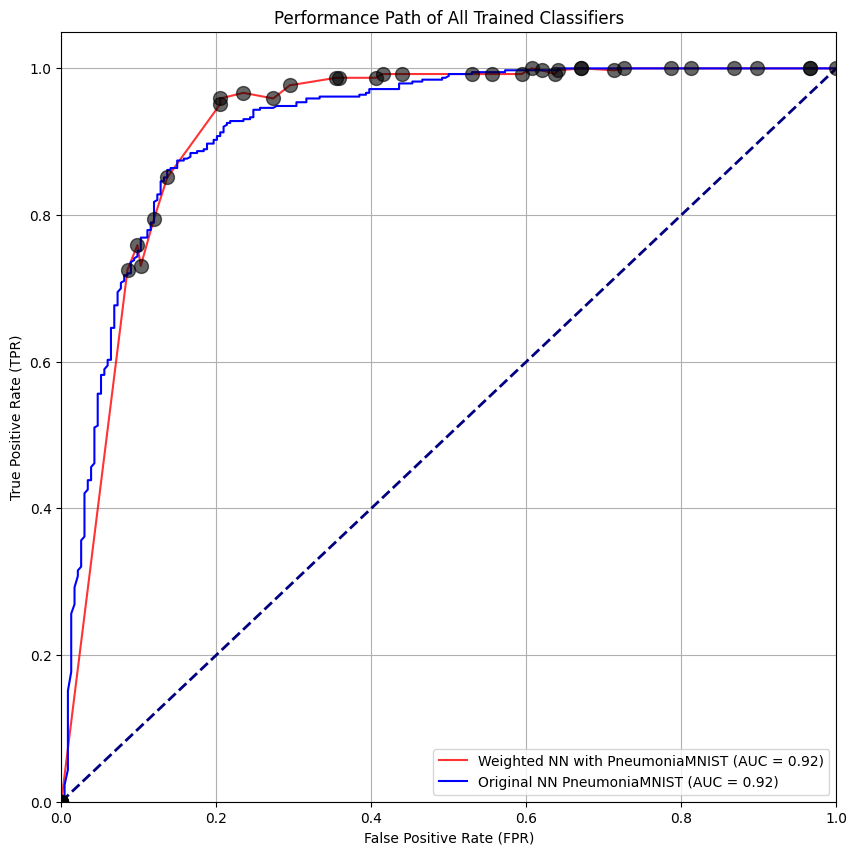

In [15]:
plot_roc_connected_points(list_weighted_clfs, results_original_roc, name="Weighted NN with PneumoniaMNIST")

/tmp/ipykernel_27715/3800948716.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  original_fprs = np.array(results_original_roc['fpr'])
/tmp/ipykernel_27715/3800948716.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  original_tprs = np.array(results_original_roc['tpr'])
/tmp/ipykernel_27715/3800948716.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  original_thresholds = np.array(results_original_roc['thresholds'])


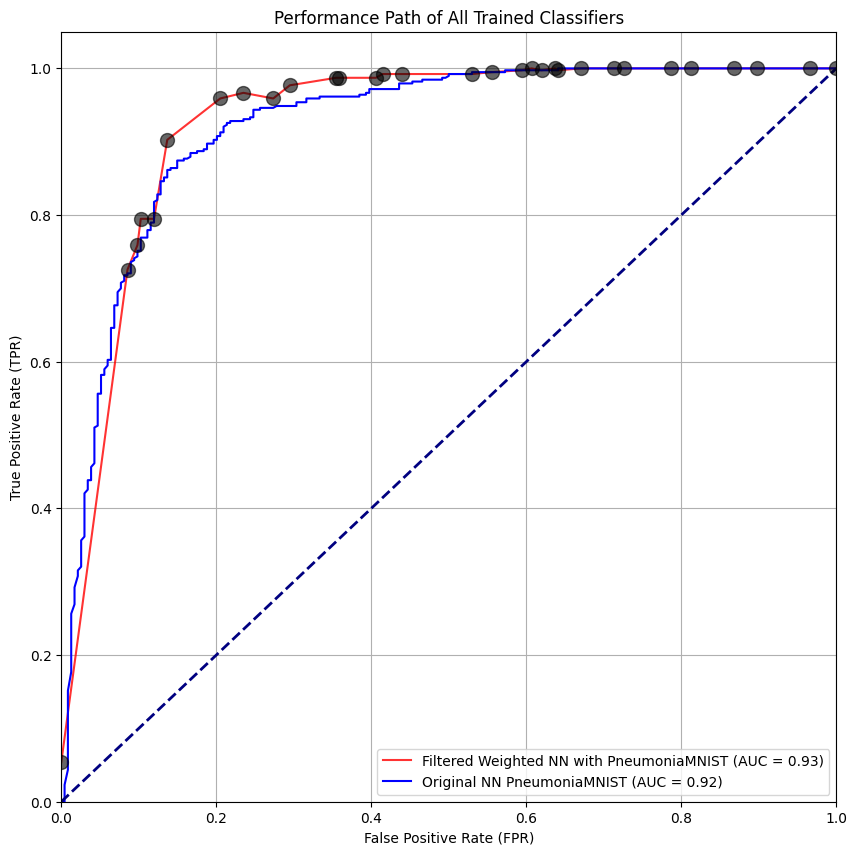

In [16]:
#filter the results
filtered_results = filter_roc_results(list_weighted_clfs, results_original_roc, depth=1)
# Plot the filtered results
plot_roc_connected_points(filtered_results, results_original_roc, name="Filtered Weighted NN with PneumoniaMNIST")